In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import json
import pickle

In [183]:
df = pd.read_csv('data/train.csv')
df.shape

(1628, 29)

In [184]:
df.columns

Index(['Id', 'Age', 'Attrition', 'BusinessTravel', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeNumber',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager', 'CommunicationSkill',
       'Behaviour'],
      dtype='object')

### Feature Engineering

In [185]:
def extract_feature(df_input):
    df = df_input.copy()
    df['OwnStocks'] = df.StockOptionLevel.apply(lambda x: 'No' if x == 0 else 'Yes')
    df['PropWorkLife'] = df.TotalWorkingYears / df.Age
    df['PropExpComp'] = df.NumCompaniesWorked / (df.TotalWorkingYears+1)
    df['PropRoleComp'] = df.YearsInCurrentRole / (df.YearsAtCompany + 1)
    df['AgeBar'] = pd.cut(df.Age, bins = [0,27,45,np.inf], labels=['Young','Mid','Old']).astype('object')
    q_pays = {
        'Laboratory Technician': 2705.0, 
        'Manufacturing Director': 5824.4000000000015, 
        'Sales Executive': 5675.8, 
        'Research Scientist': 2693.4, 
        'Sales Representative': 2325.8, 
        'Healthcare Representative': 6348.6, 
        'Research Director': 15014.600000000002, 
        'Human Resources': 2741.0, 
        'Manager': 16894.0
    }
    df['AboveQPay'] = df.apply(lambda x: 'No' if x.MonthlyIncome < q_pays.get(x.JobRole) else 'Yes', axis = 1)
    df['WorkFactors'] = (df.EnvironmentSatisfaction+df.JobSatisfaction+df.JobInvolvement) / 15
    df['CommunicationSkill'] = 1 / df['CommunicationSkill']
    cols_to_drop = [
                    'Id',
                    'Behaviour',
                    'PerformanceRating',
                    'Gender',
                    'Education', 
                    'Department',
                    'EmployeeNumber',
                    'PercentSalaryHike',
                    'YearsInCurrentRole',
                    'YearsSinceLastPromotion',
                    'YearsWithCurrManager',
                    'TrainingTimesLastYear',
                    'EducationField',
                    'StockOptionLevel',
                    'TotalWorkingYears',
                    'YearsAtCompany',
                    'NumCompaniesWorked',
                    'JobSatisfaction',
                    'EnvironmentSatisfaction',
                    'JobInvolvement',
                    'Age',
                    'MonthlyIncome',
                    #'DistanceFromHome'
                  ]
    df.drop(cols_to_drop, inplace = True, axis = 1)
    print('Columns Dropped : {}'.format(cols_to_drop))
    print('Columns in DataFrame: {}'.format(df.columns.to_list()))
    return df

In [186]:
df_cleaned = extract_feature(df)

Columns Dropped : ['Id', 'Behaviour', 'PerformanceRating', 'Gender', 'Education', 'Department', 'EmployeeNumber', 'PercentSalaryHike', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'TrainingTimesLastYear', 'EducationField', 'StockOptionLevel', 'TotalWorkingYears', 'YearsAtCompany', 'NumCompaniesWorked', 'JobSatisfaction', 'EnvironmentSatisfaction', 'JobInvolvement', 'Age', 'MonthlyIncome']
Columns in DataFrame: ['Attrition', 'BusinessTravel', 'DistanceFromHome', 'JobRole', 'MaritalStatus', 'OverTime', 'CommunicationSkill', 'OwnStocks', 'PropWorkLife', 'PropExpComp', 'PropRoleComp', 'AgeBar', 'AboveQPay', 'WorkFactors']


In [187]:
df_cleaned.dtypes

Attrition               int64
BusinessTravel         object
DistanceFromHome      float64
JobRole                object
MaritalStatus          object
OverTime               object
CommunicationSkill    float64
OwnStocks              object
PropWorkLife          float64
PropExpComp           float64
PropRoleComp          float64
AgeBar                 object
AboveQPay              object
WorkFactors           float64
dtype: object

### Preprocessing and Model Building Init

In [188]:
df_cleaned.drop_duplicates(inplace=True)
df_cleaned.shape

(1000, 14)

In [189]:
df_X = df_cleaned.drop(['Attrition'], axis = 1).copy()
df_y = df_cleaned[['Attrition']].copy()

In [190]:
nominal_type = list(df_X.select_dtypes(include='object').columns)
nominal_type

['BusinessTravel',
 'JobRole',
 'MaritalStatus',
 'OverTime',
 'OwnStocks',
 'AgeBar',
 'AboveQPay']

In [191]:
nominal_type_vals = dict()
for ot in nominal_type:
    nominal_type_vals[ot] = list(df_X[ot].unique())
print(nominal_type_vals)

{'BusinessTravel': ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently'], 'JobRole': ['Laboratory Technician', 'Manufacturing Director', 'Sales Executive', 'Research Scientist', 'Sales Representative', 'Healthcare Representative', 'Research Director', 'Human Resources', 'Manager'], 'MaritalStatus': ['Single', 'Married', 'Divorced'], 'OverTime': ['No', 'Yes'], 'OwnStocks': ['No', 'Yes'], 'AgeBar': ['Mid', 'Old', 'Young'], 'AboveQPay': ['No', 'Yes']}


In [192]:
numerical_type = list(df_X.select_dtypes(exclude='object').columns)
numerical_type

['DistanceFromHome',
 'CommunicationSkill',
 'PropWorkLife',
 'PropExpComp',
 'PropRoleComp',
 'WorkFactors']

In [193]:
ordinal_type = list()
ordinal_columns_dataset = ['EnvironmentSatisfaction',
                           'JobInvolvement',
                           'JobSatisfaction',
                           'Education',
                           'Behaviour',
                           'CommunicationSkill',
                           'PerformanceRating',
                           'StockOptionLevel',
                          ]
for col in ordinal_columns_dataset:
    if col in numerical_type:
        numerical_type.remove(col)
        ordinal_type.append(col)
        
ordinal_type

['CommunicationSkill']

In [194]:
final_cols = list(df_X.columns)
final_cols

['BusinessTravel',
 'DistanceFromHome',
 'JobRole',
 'MaritalStatus',
 'OverTime',
 'CommunicationSkill',
 'OwnStocks',
 'PropWorkLife',
 'PropExpComp',
 'PropRoleComp',
 'AgeBar',
 'AboveQPay',
 'WorkFactors']

In [195]:
numerical_index = list()
nominal_index = list()
ordinal_index = list()

for col in numerical_type:
    numerical_index.append(final_cols.index(col))
for col in nominal_type:
    nominal_index.append(final_cols.index(col))
for col in ordinal_type:
    ordinal_index.append(final_cols.index(col))

In [196]:
print('Numerical Columns')
for i,col in zip(numerical_index, numerical_type):
    print(i, col)
print('='*50)
print('Nominal Columns')
for i,col in zip(nominal_index, nominal_type):
    print(i, col)
print('='*50)
print('Ordinal Columns')
for i,col in zip(ordinal_index, ordinal_type):
    print(i, col)

Numerical Columns
1 DistanceFromHome
7 PropWorkLife
8 PropExpComp
9 PropRoleComp
12 WorkFactors
Nominal Columns
0 BusinessTravel
2 JobRole
3 MaritalStatus
4 OverTime
6 OwnStocks
10 AgeBar
11 AboveQPay
Ordinal Columns
5 CommunicationSkill


In [197]:
df_X.describe()

,DistanceFromHome,CommunicationSkill,PropWorkLife,PropExpComp,PropRoleComp,WorkFactors
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.302556,0.449400,0.286846,0.281996,0.479683,0.546667
std,0.319843,0.287856,0.153826,0.299577,0.275793,0.112008
min,0.034483,0.200000,0.000000,0.000000,0.000000,0.266667
25%,0.076923,0.250000,0.179487,0.090909,0.333333,0.466667
50%,0.142857,0.333333,0.263158,0.181818,0.500000,0.533333
75%,0.500000,0.500000,0.400000,0.385684,0.666667,0.600000
max,1.000000,1.000000,0.672727,2.250000,0.875000,0.800000


In [198]:
from sklearn.preprocessing import OneHotEncoder
encoder_dic = {}
for col in nominal_index:
    enc = OneHotEncoder(categories='auto',drop='first',sparse = False).fit(df_X.iloc[:,[col]])
    encoder_dic[col] = enc

In [199]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(df_X, df_y, test_size=0.20, random_state = 0, stratify=df_y)
X_train,X_test,y_train,y_test = X_train.reset_index(),X_test.reset_index(),y_train.reset_index(),y_test.reset_index()
X_train.drop(['index'], inplace=True, axis=1)
X_test.drop(['index'], inplace=True, axis=1)
y_train.drop(['index'], inplace=True, axis=1)
y_test.drop(['index'], inplace=True, axis=1)

In [200]:
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
#sampler = RandomOverSampler(sampling_strategy=0.7)
#X_train, y_train = sampler.fit_resample(X_train, y_train)
sampler = SMOTENC(categorical_features= nominal_index + ordinal_index, k_neighbors=3, random_state=0)
X_train, y_train = sampler.fit_resample(X_train, y_train)

In [201]:
X_train.shape

(1348, 13)

In [202]:
for i, enc in encoder_dic.items():
    temp1 = pd.DataFrame(enc.transform(X_train.iloc[:,[i]]), columns=[ list(df_X.columns)[i]+'_'+colname for colname in list(enc.categories_[0])[1:]]).reset_index()
    X_train = pd.concat( [X_train, temp1], axis = 1 )
    temp2 = pd.DataFrame(enc.transform(X_test.iloc[:,[i]]), columns=[ list(df_X.columns)[i]+'_'+colname for colname in list(enc.categories_[0])[1:]]).reset_index()
    X_test = pd.concat( [X_test, temp2], axis = 1 )

In [203]:
X_train.drop(nominal_type, inplace=True, axis=1)
X_test.drop(nominal_type, inplace=True, axis=1)

In [204]:
final_cols_encoded = X_train.columns.values
final_cols_encoded

array(['DistanceFromHome', 'CommunicationSkill', 'PropWorkLife',
       'PropExpComp', 'PropRoleComp', 'WorkFactors', 'index',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'index', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'JobRole_Research Director',
       'JobRole_Research Scientist', 'JobRole_Sales Executive',
       'JobRole_Sales Representative', 'index', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'index', 'OverTime_Yes', 'index',
       'OwnStocks_Yes', 'index', 'AgeBar_Old', 'AgeBar_Young', 'index',
       'AboveQPay_Yes'], dtype=object)

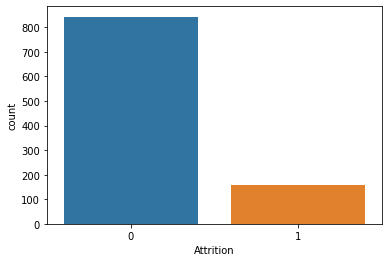

In [205]:
sns.countplot(df_y.Attrition)

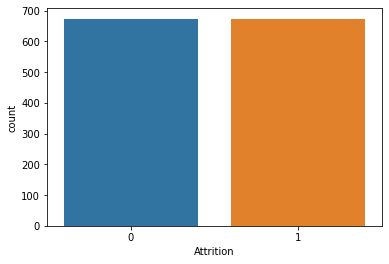

In [206]:
sns.countplot(y_train.Attrition)

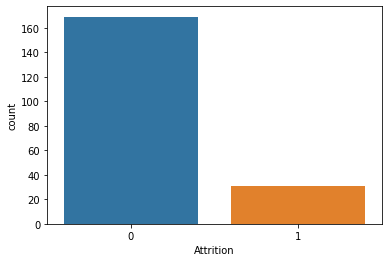

In [207]:
sns.countplot(y_test.Attrition)

In [208]:
X_train,X_test,y_train,y_test = X_train.values,X_test.values,y_train.values,y_test.values
y_train, y_test = y_train.ravel(), y_test.ravel()

In [209]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

### Building A few Models with CV

In [210]:
def check_model_perf(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    #predictions = model.predict_proba(X_test)
    #print(predictions)
    #predictions = [0 if x <= 0.4 else 1 for x in predictions[1]]
    predictions = model.predict(X_test)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()
    print(model.__class__)
    print('='*80)
    print("True Possitives  :\t{}\nTrue Negatives   :\t{}\nFalse Possitives :\t{}\nFalse Negatives  :\t{}".format(tp,tn,fp,fn))
    auc_score = metrics.roc_auc_score(y_test, predictions)
    print("AUC Score : {}".format(auc_score))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
    sns.lineplot(fpr, tpr)
    plt.title('ROC Curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()
    print("Accuracy score: {}".format(metrics.accuracy_score(y_test, predictions)))
    print("-"*40)
    print(metrics.classification_report(y_test, predictions))
    print('\n')
    return auc_score

In [212]:
cv = RepeatedStratifiedKFold(n_splits= 5, n_repeats=2, random_state=0)

#### Auto Tuning RUN ONLY IF REQD. HEAVY PROCESS

In [129]:
print('RandomForest')
rf_param_grid = {
            'n_estimators': [300,400,500,1000,1100],
            'max_features': ['auto','None',0.5,0.7,0.9],
            'max_depth': [7,9,11]
        }

gsc = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid=rf_param_grid,
        cv=cv, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
print(grid_result.best_params_)
print(grid_result.best_score_)
rf_best_param_grid = grid_result.best_params_


print('Decision Tree')
dt_param_grid = {
            'criterion': ['gini','entropy'],
            'splitter': ['best','random'],
            'max_features': ['log2','auto','None']
        }
gsc = GridSearchCV(
        estimator=DecisionTreeClassifier(),
        param_grid= dt_param_grid,
        cv=cv, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
print(grid_result.best_params_)
print(grid_result.best_score_)

dt_best_param_grid = grid_result.best_params_



print('AdaBoost')
ab_param_grid = {
            'n_estimators': [50,60,80,100],
            'learning_rate': [0.7,0.8,0.9,1]
        }

gsc = GridSearchCV(
        estimator=AdaBoostClassifier(),
        param_grid= ab_param_grid,
        cv=cv, scoring='roc_auc', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)
print(grid_result.best_params_)
print(grid_result.best_score_)

ab_best_param_grid = grid_result.best_params_

RandomForest
{'max_depth': 9, 'max_features': 0.5, 'n_estimators': 400}
0.9632806338676986
Decision Tree
{'criterion': 'entropy', 'max_features': 'auto', 'splitter': 'best'}
0.871677722498618
AdaBoost
{'learning_rate': 0.7, 'n_estimators': 50}
0.9631711606576173


<class 'sklearn.ensemble._forest.RandomForestClassifier'>
True Possitives  :	6
True Negatives   :	168
False Possitives :	1
False Negatives  :	25
AUC Score : 0.5938156136667302


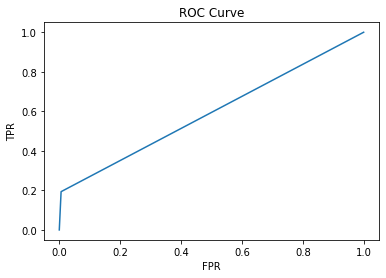

Accuracy score: 0.87
----------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.99      0.93       169
           1       0.86      0.19      0.32        31

    accuracy                           0.87       200
   macro avg       0.86      0.59      0.62       200
weighted avg       0.87      0.87      0.83       200



<class 'sklearn.tree._classes.DecisionTreeClassifier'>
True Possitives  :	7
True Negatives   :	156
False Possitives :	13
False Negatives  :	24
AUC Score : 0.5744416873449132


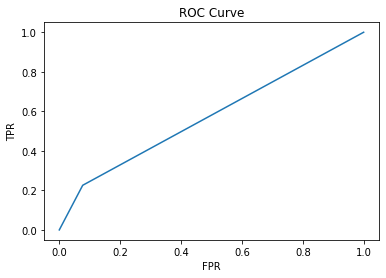

Accuracy score: 0.815
----------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       169
           1       0.35      0.23      0.27        31

    accuracy                           0.81       200
   macro avg       0.61      0.57      0.58       200
weighted avg       0.79      0.81      0.80       200



<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
True Possitives  :	10
True Negatives   :	164
False Possitives :	5
False Negatives  :	21
AUC Score : 0.6464974231723611


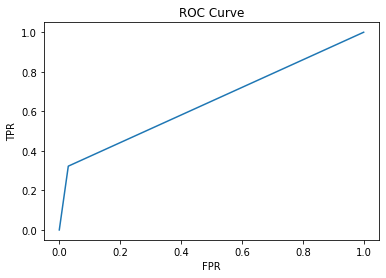

Accuracy score: 0.87
----------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       169
           1       0.67      0.32      0.43        31

    accuracy                           0.87       200
   macro avg       0.78      0.65      0.68       200
weighted avg       0.85      0.87      0.85       200





,AUC Score
AdaBoost,0.646497
Random Forest,0.593816
Decision Tree,0.574442


In [130]:
scores = dict()
scores['Random Forest'] = check_model_perf(RandomForestClassifier(**rf_best_param_grid), X_train, y_train, X_test, y_test)
scores['Decision Tree'] = check_model_perf(DecisionTreeClassifier(**dt_best_param_grid), X_train, y_train, X_test, y_test)
scores['AdaBoost'] = check_model_perf(AdaBoostClassifier(**ab_best_param_grid), X_train, y_train, X_test, y_test)
pd.DataFrame.from_dict(scores, orient='index', columns=['AUC Score']).sort_values(by=['AUC Score'], ascending=False)

#### Manual Checks

In [31]:
scores = dict()

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
True Possitives  :	7
True Negatives   :	166
False Possitives :	3
False Negatives  :	24
AUC Score : 0.6040274861614813


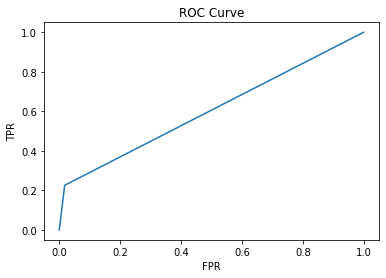

Accuracy score: 0.865
----------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       169
           1       0.70      0.23      0.34        31

    accuracy                           0.86       200
   macro avg       0.79      0.60      0.63       200
weighted avg       0.85      0.86      0.83       200





IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [216]:
scores['RandomForest'] = check_model_perf(RandomForestClassifier(max_features=0.9,n_estimators = 400, oob_score = True, max_depth=9), X_train, y_train, X_test, y_test)

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
True Possitives  :	9
True Negatives   :	152
False Possitives :	17
False Negatives  :	22
AUC Score : 0.5948654323344149


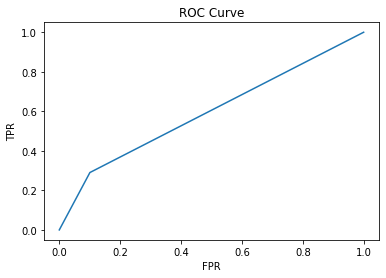

Accuracy score: 0.805
----------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.90      0.89       169
           1       0.35      0.29      0.32        31

    accuracy                           0.81       200
   macro avg       0.61      0.59      0.60       200
weighted avg       0.79      0.81      0.80       200





In [141]:
scores['DecisionTree'] = check_model_perf(DecisionTreeClassifier(max_depth=15), X_train, y_train, X_test, y_test)

<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
True Possitives  :	10
True Negatives   :	163
False Possitives :	6
False Negatives  :	21
AUC Score : 0.6435388432907043


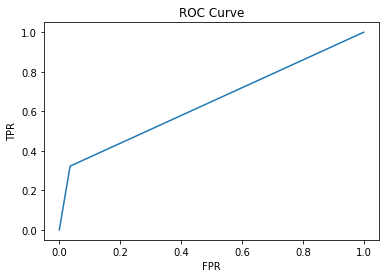

Accuracy score: 0.865
----------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       169
           1       0.62      0.32      0.43        31

    accuracy                           0.86       200
   macro avg       0.76      0.64      0.67       200
weighted avg       0.85      0.86      0.85       200





In [97]:
scores['AdaBoost'] = check_model_perf(AdaBoostClassifier(learning_rate=0.9, n_estimators=60), X_train, y_train, X_test, y_test)

<class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
True Possitives  :	12
True Negatives   :	77
False Possitives :	92
False Negatives  :	19
AUC Score : 0.42135903798434815


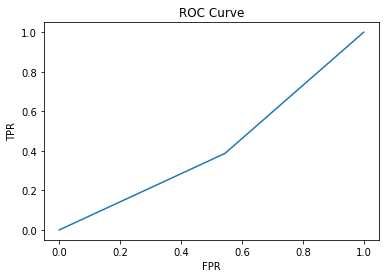

Accuracy score: 0.445
----------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.46      0.58       169
           1       0.12      0.39      0.18        31

    accuracy                           0.45       200
   macro avg       0.46      0.42      0.38       200
weighted avg       0.70      0.45      0.52       200





In [42]:
scores['SGDCalssifer'] = check_model_perf(SGDClassifier(), X_train, y_train, X_test, y_test)

<class 'sklearn.svm._classes.SVC'>
True Possitives  :	0
True Negatives   :	169
False Possitives :	0
False Negatives  :	31
AUC Score : 0.5


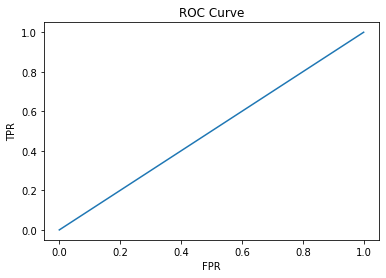

Accuracy score: 0.845
----------------------------------------
              precision    recall  f1-score   support

           0       0.84      1.00      0.92       169
           1       0.00      0.00      0.00        31

    accuracy                           0.84       200
   macro avg       0.42      0.50      0.46       200
weighted avg       0.71      0.84      0.77       200





/Users/parth/miniconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
scores['SVC'] = check_model_perf(SVC(), X_train, y_train, X_test, y_test)

<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
True Possitives  :	1
True Negatives   :	166
False Possitives :	3
False Negatives  :	30
AUC Score : 0.507253292613094


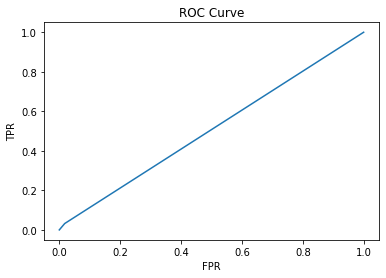

Accuracy score: 0.835
----------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       169
           1       0.25      0.03      0.06        31

    accuracy                           0.83       200
   macro avg       0.55      0.51      0.48       200
weighted avg       0.75      0.83      0.78       200





In [44]:
scores['KNN'] = check_model_perf(KNeighborsClassifier(n_neighbors = 3), X_train, y_train, X_test, y_test)

In [96]:
pd.DataFrame.from_dict(scores, orient='index', columns=['AUC Score']).sort_values(by=['AUC Score'], ascending=False)

,AUC Score
AdaBoost,0.640580
DecisionTree,0.634377
RandomForest,0.593816
KNN,0.507253
SVC,0.500000
Logistic,0.500000
SGDCalssifer,0.421359


In [218]:
scores = cross_val_score(RandomForestClassifier(max_features=0.9,n_estimators = 400, oob_score = True, max_depth=9), X_train, y_train, scoring='roc_auc', cv=cv)
scores

array([0.94463649, 0.97289438, 0.96257888, 0.94516307, 0.98286346,
       0.9581893 , 0.9522085 , 0.97251029, 0.96263129, 0.95522388])

In [217]:
scores = cross_val_score(RandomForestClassifier(max_features=0.9,n_estimators = 400, oob_score = True, max_depth=9), X_train, y_train, scoring='recall', cv=cv)
scores

array([0.84444444, 0.80740741, 0.88148148, 0.8358209 , 0.8962963 ,
       0.84444444, 0.84444444, 0.88148148, 0.87313433, 0.83703704])

### Models_for_submission

In [120]:
!mkdir models

mkdir: models: File exists


In [219]:
model = RandomForestClassifier(max_features=0.9,n_estimators = 400, oob_score = True, max_depth=9)
model.fit(X_train, y_train)
pkl_filename = "models/RandomForest.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [49]:
model = DecisionTreeClassifier(criterion='gini', max_features = 'auto', splitter='best')
model.fit(X_train, y_train)
pkl_filename = "models/DecisionTree.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [50]:
model = AdaBoostClassifier(n_estimators = 100, learning_rate=0.9)
model.fit(X_train, y_train)
pkl_filename = "models/Adaboost.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)